<a href="https://colab.research.google.com/github/Yanboding/.github/blob/main/MCIScheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os
import copy
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as RNG
from scipy.special import gamma
from pprint import pprint
import pickle
from concurrent import futures
import time

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def getInsertionIndex(element, elements, key=lambda x: x):
    low = 0
    high = len(elements) - 1
    while low <= high:
        mid = (low + high)//2
        if key(elements[mid]) == key(element):
            # if there are duplicates in the list
            if mid + 1 < len(elements) and key(elements[mid+1]) == key(element):
                low = mid + 1
            else:
                return mid + 1
        elif key(elements[mid]) < key(element):
            low = mid + 1
        else:
            high = mid - 1
    return low

class EventNotice:

    def __init__(self, eventType, eventTime, eventObject):
        self.eventType = eventType
        self.eventTime = eventTime
        self.eventObject = eventObject

class EventCalendar:

    def __init__(self):
        self.clock = 0
        self.calendar = []

    def add(self, addedEvent):
        self.calendar.insert(getInsertionIndex(addedEvent, self.calendar, key=lambda x: x.eventTime),addedEvent)

    def remove(self):
        if len(self.calendar) > 0:
            nextEvent = self.calendar.pop(0)
            self.clock = nextEvent.eventTime
            return nextEvent

    def saveRemove(self):
        buffer = defaultdict(list)
        if len(self.calendar) > 0:
            nextEvent = self.remove()
            buffer[nextEvent.eventType].append(nextEvent)
            while len(self.calendar) > 0 and self.calendar[0].eventTime == self.clock:
                nextEvent = self.remove()
                buffer[nextEvent.eventType].append(nextEvent)
        return buffer

    def __len__(self):
        return len(self.calendar)

class Node:

    def __init__(self, val):
        self.val = val
        self.prev = None
        self.next = None

    def isOrphan(self):
        return self.prev == None and self.next == None

class LinkedList:

    def __init__(self, metaData=None):
        self.head = Node(None)  # Dummy head
        self.tail = Node(None)  # Dummy tail
        self.head.next = self.tail
        self.tail.prev = self.head
        self.metaData = metaData
        self.count = 0

    def is_empty(self):
        return self.head.next == self.tail

    def add_front(self, new_node):
        new_node.next = self.head.next
        new_node.prev = self.head
        self.head.next.prev = new_node
        self.head.next = new_node
        self.count += 1

    def add_back(self, new_node):
        new_node.next = self.tail
        new_node.prev = self.tail.prev
        self.tail.prev.next = new_node
        self.tail.prev = new_node
        self.count += 1

    def remove_front(self):
        if self.is_empty():
            return None
        front_node = self.head.next
        self.head.next = front_node.next
        front_node.next.prev = self.head
        front_node.next = front_node.prev = None
        self.count -= 1
        return front_node

    def remove_back(self):
        if self.is_empty():
            return None
        back_node = self.tail.prev
        self.tail.prev = back_node.prev
        back_node.prev.next = self.tail
        back_node.next = back_node.prev = None
        self.count -= 1
        return back_node

    def remove(self, node):
        node.prev.next = node.next
        node.next.prev = node.prev
        node.next = node.prev = None
        self.count -= 1

    def __len__(self):
        return self.count

    def display(self):
        current = self.head.next
        while current != self.tail:
            print(current.val, end=' ')
            current = current.next
        print()

class TimeStat:

    def __init__(self):
        self.times = []

    def record(self, time):
        if self.times == [] or self.times[-1] <= time:
            self.times.append(time)
        elif self.times[0] > time:
            self.times.insert(0, time)
        else:
            self.times.insert(getInsertionIndex(time, self.times), time)

class Stat:

    def __init__(self, shape):
        self.shape = shape
        self.expect = np.zeros(shape)
        self.varSum = np.zeros(shape)
        self.count = 0

    def record(self, sample):
        self.count += 1
        diff = sample - self.expect
        self.expect += diff/self.count
        self.varSum += diff * (sample - self.expect)

    def mean(self):
        return self.expect

    def sample_variance(self):
        sampleVariance = np.zeros(self.shape)
        if self.count > 1:
            sampleVariance = self.varSum/(self.count-1)
        return sampleVariance

    def half_window(self, confidence):
        halfWindow = np.zeros(self.shape)
        if self.count > 1:
            sampleVariance = self.varSum/(self.count-1)
            std = np.sqrt(sampleVariance)
            t_crit = np.abs(RNG.t.ppf((1-confidence)/2, self.count-1))
            halfWindow = t_crit * std/np.sqrt(self.count)
        return halfWindow

    def sample_size(self):
        return self.count

class MCI:

    def __init__(self, patients):
        self.patients = patients
        self.numberOfPatients = len(patients)
        self.calendar = EventCalendar()
        self.abandonTimeStat = TimeStat()
        self.survivalRate = np.vectorize(self._survivalRateFun, otypes=[float])

    def _survivalRateFun(self, t):
        numberOfDeath = getInsertionIndex(t, self.abandonTimeStat.times)
        return (self.numberOfPatients - numberOfDeath) / self.numberOfPatients

    def recordDeath(self, patientId):
        self.recordLeaveTime(patientId)
        self.patients.at[patientId, 'isAbandon'] = True
        self.abandonTimeStat.record(self.patients.at[patientId, 'leaveTime'])

    def recordLeaveTime(self, patientId):
        raise NotImplemented

class Agent:

    def __init__(self, env):
        self.env = env

    def policy(self, state):
        pass

    def strategy(self, state):
        pass

In [4]:
class PatientGenerator:

    def __init__(self, classProbs, subclassProbs, notBenefitProb, impatientAverages, imagingAverages, imagingStds, surgeryAverages, surgeryStds, seed):
        self.classProbs = classProbs
        self.subclassProbs = subclassProbs
        self.notBenefitProb = notBenefitProb
        self.impatientAverages = impatientAverages
        self.imagingAverages = imagingAverages
        self.imagingStds = imagingStds
        self.surgeryAverages = surgeryAverages
        self.surgeryStds = surgeryStds

        self.classNumber = len(classProbs)
        self.subclassNumbers = [len(subclassProb) for subclassProb in subclassProbs]
        self.classAverageSurvivalTimes = [sum(prob*average for prob, average in zip(probs, averages)) for probs, averages in zip(subclassProbs, impatientAverages)]

        self.seed = seed
        # 1. patient class generator
        self.patientClassGenerator = np.random.default_rng(seed)
        # 2. patient subclass generator
        self.subclassGenerators = [np.random.default_rng(self.nextSeed()) for i in range(self.classNumber)]
        # 3. beneficiary generator
        self.beneficiaryGenerator = np.random.default_rng(self.nextSeed())
        # 4. impatient time generators
        self.impatientTimeGenerators = []
        for i in range(len(impatientAverages)):
            self.impatientTimeGenerators.append([])
            for j in range(len(impatientAverages[i])):
                impatientTimeGenerator = RNG.weibull_min(c=1.5, scale=impatientAverages[i][j]/gamma(1+1/1.5))
                impatientTimeGenerator.random_state = np.random.RandomState(seed=self.nextSeed())
                self.impatientTimeGenerators[i].append(impatientTimeGenerator)
        # 5. imaging time generator
        self.potentialImagingTimeGenerators = []
        for ctTime, ctStd in zip(imagingAverages, imagingStds):
            potentialImagingTimeGenerator = RNG.norm(loc=ctTime, scale=ctStd)
            potentialImagingTimeGenerator.random_state = np.random.RandomState(seed=self.nextSeed())
            self.potentialImagingTimeGenerators.append(potentialImagingTimeGenerator)
        # 6. surgery time
        self.potentialSurgeryTimeGenerators = []
        for averageSurgeryTime, surgeryTimeStd in zip(surgeryAverages, surgeryStds):
            sigma = np.sqrt(np.log(1 + (surgeryTimeStd**2 / averageSurgeryTime**2)))
            potentialSurgeryTimeGenerator = RNG.lognorm(s=sigma,scale=np.exp(np.log(averageSurgeryTime) - sigma**2/2))
            potentialSurgeryTimeGenerator.random_state = np.random.RandomState(seed=self.nextSeed())
            self.potentialSurgeryTimeGenerators.append(potentialSurgeryTimeGenerator)

    def nextSeed(self):
        self.seed += 1
        return self.seed

    def _rv(self):
        patientClass = self.patientClassGenerator.choice(np.arange(self.classNumber), p=self.classProbs)
        patientSubclass = self.subclassGenerators[patientClass].choice(np.arange(self.subclassNumbers[patientClass]), p=self.subclassProbs[patientClass])
        isSurgeryBeneficiary = self.beneficiaryGenerator.choice([False, True], p=[self.notBenefitProb, 1-self.notBenefitProb])
        interarrivalTime = 0
        impatientTime = self.impatientTimeGenerators[patientClass][patientSubclass].rvs()
        # Patients who are not benifit from the surgery will not die.
        if not isSurgeryBeneficiary:
            impatientTime = float('inf')
        potentialImagingTime = self.potentialImagingTimeGenerators[patientClass].rvs()
        potentialSurgeryTime = self.potentialSurgeryTimeGenerators[patientClass].rvs()
        classAverageSurvivalTime = self.classAverageSurvivalTimes[patientClass]
        subclassAverageSurvivalTime = self.impatientAverages[patientClass][patientSubclass]
        return [interarrivalTime, impatientTime, potentialImagingTime, potentialSurgeryTime, isSurgeryBeneficiary, patientClass, patientSubclass, classAverageSurvivalTime, subclassAverageSurvivalTime]



    def rvs(self, size):
        patients = [self._rv() for i in range(size)]
        return pd.DataFrame(patients,
                        columns=['interarrivalTime', 'impatientTime', 'potentialImagingTime', 'potentialSurgeryTime', 'isSurgeryBeneficiary', 'patientClass', 'patientSubclass', 'classAverageSurvivalTime', 'subclassAverageSurvivalTime'])

In [5]:
def task(EnvClass, AgentClass, patients, parameter):
    mciModel =  EnvClass(patients, **parameter['env'])
    agent = AgentClass(mciModel, **parameter['agent'])
    state = mciModel.reset()
    done = False
    info = {'where': {'CT','OR'}}
    while not done:
        action = agent.chooseAction(state, info)
        state, reward, done, info = mciModel.step(action)
    return mciModel

def simulation(EnvClass, AgentClass, parameter):
    if not os.path.exists(parameter['output']):
        os.makedirs(parameter['output'])
    replicationNumber = len(parameter['input'])
    t = parameter['t']
    survivalRateStat = Stat(t.shape)
    benefitSurvivalRateStat = Stat(t.shape)
    # Iterate directory
    '''
    with futures.ThreadPoolExecutor(max_workers=16) as executor:
        jobs = [executor.submit(task, EnvClass, AgentClass, patients, parameter) for patients in parameter['input']]
        for i, ret in enumerate(futures.as_completed(jobs)):
            mciModel = ret.result()
            patients = mciModel.patients
            outputPath = os.path.join(parameter['output'], 'patient_'+str(i)+'.csv')
            patients.to_csv(outputPath)
            survivalRateSamplePath = mciModel.survivalRate(t)
            benefitSurvivalRateSamplePath = survivalRateSamplePath - len(patients[patients['isSurgeryBeneficiary'] == False]) /len(patients)
            survivalRateStat.record(survivalRateSamplePath)
            benefitSurvivalRateStat.record(benefitSurvivalRateSamplePath)
    '''
    for i, patients in enumerate(parameter['input']):
        mciModel =  EnvClass(patients, **parameter['env'])
        agent = AgentClass(mciModel, **parameter['agent'])
        state = mciModel.reset()
        done = False
        info = {'where': {'CT','OR'}}
        while not done:
            action = agent.chooseAction(state, info)
            state, reward, done, info = mciModel.step(action)
        outputPath = os.path.join(parameter['output'], 'patient_'+str(i)+'.csv')
        state.to_csv(outputPath)
        survivalRateSamplePath = mciModel.survivalRate(t)
        benefitSurvivalRateSamplePath = survivalRateSamplePath - len(patients[patients['isSurgeryBeneficiary'] == False]) /len(patients)
        survivalRateStat.record(survivalRateSamplePath)
        benefitSurvivalRateStat.record(benefitSurvivalRateSamplePath)

    return {
        'survivalRateStat': survivalRateStat,
        'benefitSurvivalRateStat': benefitSurvivalRateStat
    }

Ordinal triage policy: utilize CT (while avoiding OR idleness) according to a static priority based on customer class; prioritize the class (including sub-classes identified by CT) with shorter mean remaining survival time, unless the survival time is deemed too short for patients of that class to survive the surgery.

How do we compare the survival times of patients who finished imaging to those waiting for imaging? Do we consider patients who are waiting for imaging as a different class?

Yes, for those patients we have a high-variance survival distribution. We can think about more sophisticated policies but for now we can just prioritize based on mean remaining survival time (ignoring variance).

In [ ]:
class OrdinalTriageAgent(Agent):

    def __init__(self, env, threshold):
        super().__init__(env)
        self.threshold = threshold
        self.resourceRank = {None: 0, 'CT': 1, 'OR':2}

    def chooseAction(self, state, info=None):
        # sorted [id, averageSurvivalTime, currentResource] sort based on (averageSurvivalTime, currentResource)
        # currentResource rule: None > CT > OR
        # select state.index as patientId, subclassAverageSurvivalTime as averageSurvivalTime, currentResource
        # from state
        # where currentQueue != 0 and isUsedORroom = False
        # union
        # select state.index as patientId, classAverageSurvivalTime as averageSurvivalTime, currentResource
        # from state
        # where currentQueue = 0 and isUsedORroom = False
        # OR queue: [(average, rank, number)]
        # ct queue: [(average, rank, number)]
        orPatientIds = pd.DataFrame([]).index
        ctPatientIds = pd.DataFrame([]).index
        patientsInSys = state[(state['leaveTime'].isnull())&(state['isUsedORroom']==False)].copy()
        patientsInSys['rank'] = patientsInSys['currentResource'].apply(lambda a: self.resourceRank[a])
        patientsInCTQueue = patientsInSys[patientsInSys['currentQueue'] == 0][['classAverageSurvivalTime', 'rank']]\
        .rename(columns={"classAverageSurvivalTime": "averageSurvivalTime"})
        if 'OR' in info['where']:
            patientsInORQueue = patientsInSys[patientsInSys['currentQueue'] != 0][['subclassAverageSurvivalTime', 'rank']]\
            .rename(columns={"subclassAverageSurvivalTime": "averageSurvivalTime"})
            decisionSpace = pd.concat([patientsInORQueue, patientsInCTQueue])\
            .sort_values(by=['averageSurvivalTime', 'rank'])
            savableMask = decisionSpace['averageSurvivalTime'] > self.threshold
            orPatientIds = pd.concat([decisionSpace[savableMask], decisionSpace[~savableMask]])[:(self.env.orRoomNumber - len(self.env.busyORrooms))].index
        if 'CT' in info['where']:
            ctPatientIds = patientsInCTQueue.loc[(~patientsInCTQueue.index.isin(orPatientIds))&(patientsInCTQueue['rank']==0)]\
            .sort_values(by=['averageSurvivalTime'])[:(self.env.ctRoomNumber - len(self.env.busyCTRooms))]\
            .index

        #print(ctPatientIds, orPatientIds, self.env.orRoomNumber - len(self.env.busyORrooms), self.env.ctRoomNumber - len(self.env.busyCTRooms))
        return {'CT':ctPatientIds.to_list(), 'OR': orPatientIds.to_list()}

Baseline Policy: no CT usage, and static prioritization for OR based on the location of the gunshot (giving priority to the class with shortest mean survival time).

In [6]:
class BaselineAgent(Agent):

    def __init__(self, env):
        super().__init__(env)

    def chooseAction(self, state, info):
        if 'OR' not in info['where']:
            return {'CT':[], 'OR': []}
        # select patientId
        # from state where leaveTime = NaN and isUsedORroom = False
        # sort by classAverageSurvivalTime
        # limit env.orRoomNumber - len(env.busyORrooms)
        patientIds = state[(state['leaveTime'].isnull())&(state['isUsedORroom']==False)]\
        .sort_values(by=['classAverageSurvivalTime'])[:(self.env.orRoomNumber - len(self.env.busyORrooms))]\
        .index.to_list()
        return {'CT':[], 'OR': patientIds}

In [118]:
class BaselineAgent(Agent):
    def __init__(self, env, threshold=0):
        super().__init__(env)
        self.threshold = threshold

    def getFirstNElement(self, order, resources, idle):
        res = []
        for (average, rank) in order:
            resource = resources[(average, rank)]
            while len(resource) > 0:
                res.append(resource.remove_front())
                idle -= 1
                if idle <= 0:
                    return res
        return res

    def chooseAction(self, state, info):
        if 'OR' not in info['where']:
            return {'CT':[], 'OR': []}
        ctQueue = state['ctQueue']
        keys = list(ctQueue.keys())
        i = getInsertionIndex((self.threshold,), keys, key=lambda x: x[0])
        orNodes = self.getFirstNElement(keys[i:]+keys[:i], ctQueue, self.env.orRoomNumber - len(self.env.busyORrooms))
        return {'CT':[], 'OR': orNodes}

In [67]:
class OrdinalTriageAgent(Agent):
    OR_QUEUE, CT_QUEUE, CT = 0,1,2
    def __init__(self, env, threshold):
        super().__init__(env)
        self.threshold = threshold

    def getFirstNElement(self, order, resources, idle):
        res = []
        for (average, rank) in order:
            resource = resources[(average, rank)]
            while len(resource) > 0:
                if rank == self.CT:
                    res.append(resource.pop())
                else:
                    res.append(resource.remove_front())
                idle -= 1
                if idle <= 0:
                    return res
        return res

    def chooseAction(self, state, info=None):
        waiting, ctQueue = state['waiting'], state['ctQueue']
        # sort keys
        keys = list(waiting.keys())
        i = getInsertionIndex((self.threshold,), keys, key=lambda x: x[0])
        orNodes = self.getFirstNElement(keys[i:]+keys[:i], waiting, self.env.orRoomNumber - len(self.env.busyORrooms))
        ctNodes = self.getFirstNElement(ctQueue.keys(), ctQueue, self.env.ctRoomNumber - self.env.busyCTRoomsNumber())
        return {'CT':ctNodes, 'OR': orNodes}

In [119]:
class FastMultiClassMCIEnv(MCI):
    OR_QUEUE, CT_QUEUE, CT = 0,1,2
    def __init__(self, patients, impatientAverages, subclassProbs, ctRoomNumber, orRoomNumber):
        super().__init__(patients)
        self.patients = patients
        self.impatientAverages = impatientAverages
        self.subclassProbs = subclassProbs
        self.ctRoomNumber = ctRoomNumber
        self.orRoomNumber = orRoomNumber

    def reset(self):
        self.busyORrooms = set()
        # Track patients that are currently in CT rooms
        self.busyCTRooms = {}

        waiting = {}
        ctQueue = {}
        for probs, impatients in zip(self.subclassProbs, self.impatientAverages):
            classAverage = 0
            for prob, impatient in zip(probs, impatients):
                classAverage += prob * impatient
                waiting[(impatient, self.OR_QUEUE)] = LinkedList()
            waiting[(classAverage, self.CT_QUEUE)] = LinkedList()
            ctQueue[(classAverage, self.CT_QUEUE)] = waiting[(classAverage, self.CT_QUEUE)]
            waiting[(classAverage, self.CT)] = set()
            self.busyCTRooms[(classAverage, self.CT)] = waiting[(classAverage, self.CT)]
        self.waiting = {key: waiting[key] for key in sorted(waiting)}
        self.ctQueue = {key: ctQueue[key] for key in sorted(ctQueue)}

        self.patients['arrivalTime'] = self.patients['interarrivalTime'].cumsum()
        self.patients['abandonTime'] = self.patients['arrivalTime'] + self.patients['impatientTime']
        self.patients['isAbandon'] = False
        self.patients['isUsedORroom'] = False
        self.patients['isUsedCTroom'] = False
        self.patients['leaveTime'] = np.NaN
        self.patients['node'] = None
        self.patients['currentResource'] = None
        for i, patient in self.patients.iterrows():
            node = Node((i, patient))
            self.patients.at[i, 'node'] = node
            self.patients.at[i, 'currentQueue'] = self.ctQueue[(patient.classAverageSurvivalTime, self.CT_QUEUE)]
            self.ctQueue[(patient.classAverageSurvivalTime, self.CT_QUEUE)].add_back(node)
            if patient['abandonTime'] < float('inf'):
                self.calendar.add(EventNotice('Abandon', patient['abandonTime'], node))
        return {'waiting': self.waiting, 'ctQueue': self.ctQueue}

    def busyCTRoomsNumber(self):
        return sum(len(resource) for resource in self.busyCTRooms.values())

    def _checkStateStatus(self):
        numberOfPatientsInCTSystem = 0
        numberOfPatientsInSystem = 0
        for (averageSurvival, rank), resource in self.waiting.items():
            if self.CT_QUEUE == rank or self.CT == rank:
                numberOfPatientsInCTSystem += len(resource)
            numberOfPatientsInSystem += len(resource)
        where = set()
        isNeedAction = False
        if self.busyCTRoomsNumber() < min(numberOfPatientsInCTSystem, self.ctRoomNumber):
            where.add('CT')
            isNeedAction = True
        if len(self.busyORrooms) < min(numberOfPatientsInSystem, self.orRoomNumber):
            where.add('OR')
            isNeedAction = True
        isDone = numberOfPatientsInSystem == 0
        return isNeedAction, isDone, {'where': where}

    def recordLeaveTime(self, patientId):
        patient = self.patients.iloc[patientId]
        if patient.currentQueue:
            patient.currentQueue.remove(patient.node)
        self.patients.at[patientId, 'currentResource'] = None
        self.patients.at[patientId, 'currentQueue'] = None
        self.patients.at[patientId, 'node'] = None
        self.patients.at[patientId, 'leaveTime'] = self.calendar.clock

    def abandon(self, node):
        # patientId, patient = node.val
        patientId, patient = node.val
        patient = self.patients.iloc[patientId]
        # check if the patient has left the system.
        if patient.node == None:
            return 0
        # die in surgery
        elif node in self.busyCTRooms[(patient.classAverageSurvivalTime, self.CT)]:
            self.busyCTRooms[(patient.classAverageSurvivalTime, self.CT)].remove(node)
        elif node in self.busyORrooms:
            self.busyORrooms.remove(node)
        self.recordDeath(patientId)
        return 1

    def endOfImaging(self, node):
        patientId, patient = node.val
        # check if the patient is still in ct room. It is possible that the patient has entered to surgery rooms
        if not node in self.busyCTRooms[(patient.classAverageSurvivalTime, self.CT)]:
            return
        self.busyCTRooms[(patient.classAverageSurvivalTime, self.CT)].remove(node)
        if not patient.isSurgeryBeneficiary:
            self.recordLeaveTime(patientId)
        else:
            queueIndex = (patient.subclassAverageSurvivalTime, self.OR_QUEUE)
            self.waiting[queueIndex].add_back(node)
            self.patients.at[patientId, 'currentResource'] = None
            self.patients.at[patientId, 'currentQueue'] = self.waiting[queueIndex]

    def endOfSurgery(self, node):
        self.busyORrooms.remove(node)
        self.recordLeaveTime(node.val[0])

    def enterORrooms(self, nodes):
        for node in nodes:
            patientId, patient = node.val
            self.busyORrooms.add(node)
            endOfSurgeryTime = self.calendar.clock + patient['potentialSurgeryTime']
            if self.patients.at[patientId, 'abandonTime'] > endOfSurgeryTime:
                self.calendar.add(EventNotice('EndOfSurgery', endOfSurgeryTime, node))

            self.patients.at[patientId, 'isUsedORroom'] = True
            self.patients.at[patientId, 'currentResource'] = 'OR'
            self.patients.at[patientId, 'currentQueue'] = None

    def enterCTRooms(self, nodes):
        for node in nodes:
            patientId, patient = node.val
            self.busyCTRooms[(patient.classAverageSurvivalTime, self.CT)].add(node)
            endOfImagingTime = self.calendar.clock + patient['potentialImagingTime']
            if self.patients.at[patientId, 'abandonTime'] > endOfImagingTime:
                self.calendar.add(EventNotice('EndOfImaging', endOfImagingTime, node))

            self.patients.at[patientId, 'isUsedCTroom'] = True
            self.patients.at[patientId, 'currentResource'] = 'CT'
            self.patients.at[patientId, 'currentQueue'] = None

    def step(self, action):
        # part 1: choose someone from all classes to enter OR room
        self.enterORrooms(action['OR'])
        # part 2: choose someone from ct queue to enter CT room
        self.enterCTRooms(action['CT'])
        # handle same timestamp event at the same time
        death = 0
        while len(self.calendar) > 0:
            buffer = self.calendar.saveRemove()
            for event in buffer['Abandon']:
                death += self.abandon(event.eventObject)
            for event in buffer['EndOfImaging']:
                self.endOfImaging(event.eventObject)
            for event in buffer['EndOfSurgery']:
                self.endOfSurgery(event.eventObject)
            needAction, done, info = self._checkStateStatus()
            if needAction:
                return {'waiting': self.waiting, 'ctQueue': self.ctQueue}, death, done, info
        return {'waiting': self.waiting, 'ctQueue': self.ctQueue}, death, done, info

2.7925236225128174


,abandonTime,isAbandon,leaveTime
0,7.507864,True,7.507864
1,188.606150,True,188.606150
2,335.133713,True,335.133713
3,287.011446,True,287.011446
4,294.383929,True,294.383929
5,53.461193,True,53.461193
6,1259.359918,False,560.934978
7,55.559872,True,55.559872
8,222.638410,True,222.638410
9,149.659731,True,149.659731


In [ ]:
import pandas as pd

# Create a sample DataFrame
data = {'Name': ['Aiyana', 'Anisha'],
        'Mathematics': [95, 98],
        'Science': [99, 94]}
df = pd.DataFrame([], columns=['Name', 'Mathematics', 'Science'])

# Display the original DataFrame
print("Original DataFrame:")
print(df)

# Define the new row to be added
new_row = {'Name': 'Saanvi', 'Mathematics': 96, 'Science': 90}

# Use the loc method to add the new row to the DataFrame
df.loc[len(df)] = new_row

# Display the modified DataFrame
print("\n\nModified DataFrame:")
print(df.loc[len(df)-1])

Original DataFrame:
Empty DataFrame
Columns: [Name, Mathematics, Science]
Index: []


Modified DataFrame:
Name           Saanvi
Mathematics        96
Science            90
Name: 0, dtype: object


To do:
1. patients who can enter OR rooms: [(patientId, averageImpatientTime, rank)]
2. patients who can enter CT rooms: [(patientId, averageImpatientTime, rank)]
steps:
1. init all patients are in CT queue:
     patients who can enter OR rooms: [(patientId, ClassAverage, 0)] sorted
     patients who can enter CT rooms: [(patientId, ClassAverage, 0)] sorted
2. if someone entered


In [ ]:
# patient: [interarrivalTime, impatientTime, imagingTime, surgeryTime, isSurgeryBeneficiary, patientClass, patientSubclass, classAverageSurvivalTime, subclassAverageSurvivalTime]
# queue info: [average survival time]
class MultiClassMCIEnv(MCI):

    def __init__(self, patients, subClassNumbers, ctRoomNumber, orRoomNumber):
        super().__init__(patients)
        self.patients = patients
        # sort patient on survival time because patients will enter service from low to high
        self.subClassNumbers = subClassNumbers
        self.ctRoomNumber = ctRoomNumber
        self.orRoomNumber = orRoomNumber
        # Track patients that are currently in surgery rooms
        self.busyORrooms = set()
        # Track patients that are currently in CT rooms
        self.busyCTRooms = set()
        # Track queue for each group
        # give each class a queue len(subClassNumbers) + sum(subClassNumbers)
        # ctqueues = [LinkedList() for _ in range(len(subClassNumbers))]
        # queues = ctqueues + [LinkedList() for _ in range(sum(subClassNumbers))]
        # impatientAverages = [[200, 450], [100, 600]]
        # classProbs = [0.27, 0.73]
        # subclassProbs = [[0.8, 0.2], [0.4, 0.6]]
        # averageQueueMap = {classAverageSurvivalTime: LinkedList() for }
        self.queues = [LinkedList({}) for _ in range(sum(subClassNumbers)+1)]
        # the queue index after imaging start at 1
        self._queueStartIndexs = np.cumsum([0]+subClassNumbers[:-1]) + 1

    '''
    def get_state(self):
        # ct Queue
        res = [(averageTime, n, rank)]
        x = self.queues[0]
        for queue in self.queues[1:]:
            if not queue.is_empty():
                averageTime =
    '''

    def reset(self):
        self.patients['arrivalTime'] = self.patients['interarrivalTime'].cumsum()
        self.patients['abandonTime'] = self.patients['arrivalTime'] + self.patients['impatientTime']
        self.patients['isAbandon'] = False
        self.patients['isUsedORroom'] = False
        self.patients['isUsedCTroom'] = False
        self.patients['leaveTime'] = np.NaN
        self.patients['node'] = None
        self.patients['currentQueue'] = 0
        self.patients['currentResource'] = None
        for i, patient in self.patients.iterrows():
            # node = Node((i, patient))
            node = Node(i)
            self.patients.at[i, 'node'] = node
            self.queues[0].add_back(node)
            #update matadata
            # self.queues[0].mataData['averageTime'][patient['classAverageSurvivalTime']] += 1
            self.calendar.add(EventNotice('Abandon', patient['abandonTime'], node))
        return self.patients

    def _getQueueIndexAfterImaging(self, patient):
        return self._queueStartIndexs[patient.patientClass] + patient.patientSubclass

    def _checkStateStatus(self):
        numberOfPatientsInCTSystem = len(self.queues[0])
        numberOfPatientsInSystem = sum(len(queue) for queue in self.queues)
        where = set()
        isNeedAction = False
        if len(self.busyCTRooms) < min(numberOfPatientsInCTSystem, self.ctRoomNumber):
            where.add('CT')
            isNeedAction = True
        if len(self.busyORrooms) < min(numberOfPatientsInSystem, self.orRoomNumber):
            where.add('OR')
            isNeedAction = True
        isDone = numberOfPatientsInSystem == 0
        return isNeedAction, isDone, {'where': where}

    def recordLeaveTime(self, patientId):
        patient = self.patients.iloc[patientId]
        self.queues[int(patient.currentQueue)].remove(patient.node)
        self.patients.at[patientId, 'currentResource'] = None
        self.patients.at[patientId, 'currentQueue'] = None
        self.patients.at[patientId, 'node'] = None
        self.patients.at[patientId, 'leaveTime'] = self.calendar.clock

    def abandon(self, node):
        # patientId, patient = node.val
        patientId = node.val
        patient = self.patients.iloc[patientId]
        # check if the patient has left the system.
        if patient.node == None:
            return 0
        # die in surgery
        elif node in self.busyCTRooms:
            self.busyCTRooms.remove(node)
        elif node in self.busyORrooms:
            self.busyORrooms.remove(node)
        self.recordDeath(patientId)
        return 1

    def endOfImaging(self, node):
        # check if the patient is still in ct room. It is possible that the patient has entered to surgery rooms
        if not node in self.busyCTRooms:
            return
        # patientId, patient = node.val
        patientId = node.val
        patient = self.patients.iloc[patientId]
        self.busyCTRooms.remove(node)
        if not patient.isSurgeryBeneficiary:
            self.recordLeaveTime(patientId)
        else:
            queueIndex = self._getQueueIndexAfterImaging(patient)
            # queue = self.queues[int(patient.currentQueue)]
            #self.queues[0].mataData['averageTime'][patient['classAverageSurvivalTime']] += 1
            self.queues[int(patient.currentQueue)].remove(patient.node)
            self.queues[queueIndex].add_back(node)
            self.patients.at[patientId, 'currentResource'] = None
            self.patients.at[patientId, 'currentQueue'] = queueIndex

    def endOfSurgery(self, node):
        self.busyORrooms.remove(node)
        self.recordLeaveTime(node.val)
    '''
    def enterCTRooms(self, nodes):
        pass

    def enterORrooms(self, nodes):
        pass
    '''
    def enterCTRooms(self, patientIds):
        for i in patientIds:
            node = self.patients.at[i, 'node']
            self.busyCTRooms.add(node)
            endOfImagingTime = self.calendar.clock + self.patients.at[i, 'potentialImagingTime']
            if self.patients.at[i, 'abandonTime'] > endOfImagingTime:
                self.calendar.add(EventNotice('EndOfImaging', endOfImagingTime, node))

            self.patients.at[i, 'isUsedCTroom'] = True
            self.patients.at[i, 'currentResource'] = 'CT'

    def enterORrooms(self, patientIds):
        for i in patientIds:
            node = self.patients.at[i, 'node']
            if node in self.busyCTRooms:
                self.busyCTRooms.remove(node)
            self.busyORrooms.add(node)
            endOfSurgeryTime = self.calendar.clock + self.patients.at[i, 'potentialSurgeryTime']
            if self.patients.at[i, 'abandonTime'] > endOfSurgeryTime:
                self.calendar.add(EventNotice('EndOfSurgery', endOfSurgeryTime, node))

            self.patients.at[i, 'isUsedORroom'] = True
            self.patients.at[i, 'currentResource'] = 'OR'


    def step(self, action):
        # Before CT, we don’t know whether they would benefit from surgery or not. In this case, we can prioritize patients from classes with higher probability of getting benefit from surgery.
        # How do we compare the survival times of patients who finished imaging to those waiting for imaging? Do we consider patients who are waiting for imaging as a different class?
        # Yes, for those patients we have a high-variance survival distribution. We can think about more sophisticated policies but for now we can just prioritize based on mean remaining survival time (ignoring variance).
        # action: {'CT':[], 'OR': []}
        # part 1: choose someone from ct queue to enter CT room
        self.enterCTRooms(action['CT'])
        # part 2: choose someone from all classes to enter OR room
        self.enterORrooms(action['OR'])
        # handle same timestamp event at the same time
        death = 0
        while len(self.calendar) > 0:
            buffer = self.calendar.saveRemove()
            for event in buffer['Abandon']:
                death += self.abandon(event.eventObject)
            for event in buffer['EndOfImaging']:
                self.endOfImaging(event.eventObject)
            for event in buffer['EndOfSurgery']:
                self.endOfSurgery(event.eventObject)
            needAction, done, info = self._checkStateStatus()
            if needAction:
                return self.patients, death, done, info
        return self.patients, death, done, info

In [ ]:
def set_fontsize(ax, size):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)

def performancePlot(performanceStat, includeText=True):
    fig, ax = plt.subplots(1,1,figsize=(20, 10))
    ax.set_xlabel(performanceStat['x']['label'])
    ax.set_ylabel("Survival Rate")

    for d in performanceStat['y']:
        d['average_data'] = np.array(d['average_data'])
        d['half_window'] = np.array(d['half_window'])
        ax.plot(performanceStat['x']['data'], d['average_data'], '--', label=d['label'])
        if includeText:
            for xdata, ydata, yhw in zip(performanceStat['x']['data'], d['average_data'], d['half_window']):
                ax.text(xdata, ydata, '{:g}'.format(float('{:.2g}'.format(ydata)))+'+-'+'{:g}'.format(float('{:.1g}'.format(yhw))), color="red", fontsize=12)
        ax.fill_between(performanceStat['x']['data'], (d['average_data'] - d['half_window']), (d['average_data'] + d['half_window']), alpha=.1)
    set_fontsize(ax, 20)
    plt.legend(fontsize=13)
    plt.show()

def plotSavedExperiment(experimentName, includeText=True):
    directoryPath = "/content/drive/MyDrive/MCIScheduling"
    with open(os.path.join(directoryPath, experimentName+'.pkl'), 'rb') as fp:
        data = pickle.load(fp)
        print(data)
        performancePlot(data,includeText)

def plotAverage(func, includeText=True):
    directoryPath = "/content/drive/MyDrive/MCIScheduling"
    def performanceStatPlot(*args, **kargs):
        performanceStat = func(*args, **kargs)
        performancePlot(performanceStat, includeText)
        # save data
        if not os.path.exists(directoryPath):
            os.mkdir(directoryPath)
        # Write a result to file to Google Drive
        with open(os.path.join(directoryPath, func.__name__+'.pkl'), 'wb') as fp:
            pickle.dump(performanceStat, fp)
            print('dictionary saved successfully to file')
    return performanceStatPlot

def heatMap(performanceStat, includeText=True):
    mean = performanceStat['data']['mean']
    half_window = performanceStat['data']['half_window']
    x_values = performanceStat['x']['values']
    y_values = performanceStat['y']['values']
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.set_xlabel(performanceStat['x']['label'])
    ax.set_ylabel(performanceStat['y']['label'])
    ax.set_title('Survival rate')
    ax.set_xticks(np.arange(len(x_values)), x_values)
    ax.set_yticks(np.arange(len(y_values)), y_values)
    im = ax.imshow(mean, cmap='coolwarm', interpolation='nearest')
    if includeText:
        for i in range(len(mean)):
            for j in range(len(mean[0])):
                s = f'{mean[i][j]:.2g}\n({(mean[i][j]-half_window[i][j]):.2g},{(mean[i][j]+half_window[i][j]):.2g})'
                #s = '{:g}'.format(float('{:.2g}'.format(mean[i][j])))+'+-'+'{:g}'.format(float('{:.1g}'.format(half_window[i][j])))
                ax.text(j, i, s, ha='center', va='center', color='black')
    set_fontsize(ax, 20)
    fig.colorbar(im, ax=ax)
    plt.show()

def plotHeatMap(func, includeText=True):
    directoryPath = "/content/drive/MyDrive/MCIScheduling"
    def heatMapPlot(*args, **kargs):
        performanceStat = func(*args, **kargs)
        heatMap(performanceStat, includeText)
        # save data
        if not os.path.exists(directoryPath):
            os.mkdir(directoryPath)
        # Write a result to file to Google Drive
        with open(os.path.join(directoryPath, func.__name__+'.pkl'), 'wb') as fp:
            pickle.dump(performanceStat, fp)
            print('dictionary saved successfully to file')
    return heatMapPlot

In [ ]:
def get_default_params():
    return {
                'patientNumber': 50,
                'ctRoomNumber': 2,
                'orRoomNumber': 3,
                'classProbs': [0.27, 0.73],
                'subclassProbs': [[0.8, 0.2], [0.4, 0.6]],
                'notBenefitProb': 0.23,
                'impatientAverages': [[200, 450], [100, 600]],
                'imagingAverages': [12, 12],
                'imagingStds': [3, 3],
                'surgeryAverages': [103, 103],
                'surgeryStds': [30, 30]
            }

def createParameter(patientNumber, ctRoomNumber, orRoomNumber, classProbs, subclassProbs, notBenefitProb, impatientAverages, imagingAverages, imagingStds, surgeryAverages, surgeryStds):
    input = './input'
    if not os.path.exists(input):
        os.makedirs(input)
    replicationNumber = 500
    patientGenerator = PatientGenerator(classProbs, subclassProbs, notBenefitProb, impatientAverages, imagingAverages, imagingStds, surgeryAverages, surgeryStds, 42)
    patientsList = []
    for i in range(replicationNumber):
        patients = patientGenerator.rvs(patientNumber)
        path = os.path.join(input, 'patients_'+str(i)+'.csv')
        patients.to_csv(path)
        patientsList.append(patients)
    stopTime =2000
    return {
                'env':{
                    'subClassNumbers': [len(probs) for probs in subclassProbs],
                    'ctRoomNumber': ctRoomNumber,
                    'orRoomNumber': orRoomNumber,
                },
                'agent': {},
                'input': patientsList,
                'output': './output',
                't': np.linspace(0, stopTime, stopTime+1)
            }

In [ ]:
def experiment_time():
    params = get_default_params()
    agents = {'Baseline': BaselineAgent,
              'Ordinal': OrdinalTriageAgent
            }
    paperParameter = createParameter(**params)
    x = paperParameter['t']
    y = []
    performanceStat = {}
    for name, agent in agents.items():
        parameter = copy.copy(paperParameter)
        parameter['output'] = os.path.join(parameter['output'], name)
        if name == 'Ordinal':
            parameter['agent']['threshold'] = 103
        print('Policy name:', name)
        res = simulation(MultiClassMCIEnv, agent, parameter)

        expectSurvivalRates = res['survivalRateStat'].mean()
        expectSurvivalRate = expectSurvivalRates[-1]
        survivalRateHalfWindows = res['survivalRateStat'].half_window(0.95)
        survivalRateHalfWindow = survivalRateHalfWindows[-1]
        print("Expected Survival Rate:", round(expectSurvivalRate,2), "+-", round(survivalRateHalfWindow,2))
        print('Improve:', '{:g}'.format(float('{:.2g}'.format(expectSurvivalRate))), "+-", '{:g}'.format(float('{:.1g}'.format(survivalRateHalfWindow))))

        expectBenefitSurvivalRates = res['benefitSurvivalRateStat'].mean()
        expectBenefitSurvivalRate = res['benefitSurvivalRateStat'].mean()[-1]
        benefitSurvivalRateHalfWindows = res['benefitSurvivalRateStat'].half_window(0.95)
        benefitSurvivalRateHalfWindow = benefitSurvivalRateHalfWindows[-1]
        print("Expected Benefit Survival Rate:", round(expectBenefitSurvivalRate,2), "+-", round(benefitSurvivalRateHalfWindow,2))

        y.append({'label':name, 'average_data': expectSurvivalRates, 'half_window': survivalRateHalfWindows})
        #y.append({'label':name+' (PWB)', 'average_data': expectBenefitSurvivalRates, 'half_window': benefitSurvivalRateHalfWindows})
        performanceStat[name] = {'expectSurvivalRate': expectSurvivalRates,
                                 'survivalRateSampleVariance': res['survivalRateStat'].sample_variance(),
                                 'survivalRateHalfWindow': survivalRateHalfWindows,
                                 'expectBenefitSurvivalRate': expectBenefitSurvivalRate,
                                 'benefitSurvivalRateSampleVariance': res['benefitSurvivalRateStat'].sample_variance(),
                                 'benefitSurvivalRateHalfWindow': benefitSurvivalRateHalfWindows,
                                 'sampleSize': res['survivalRateStat'].sample_size()
                                 }
        meanDiff = performanceStat[name]['expectSurvivalRate'][-1] - performanceStat['Baseline']['expectSurvivalRate'][-1]
        sampleVar1, sampleSize1 = performanceStat['Baseline']['survivalRateSampleVariance'][-1], performanceStat['Baseline']['sampleSize']
        sampleVar2, sampleSize2 = performanceStat[name]['survivalRateSampleVariance'][-1], performanceStat[name]['sampleSize']
        halfWindow = 1.96 * np.sqrt(sampleVar1/sampleSize1 + sampleVar2/sampleSize2)
        print('Improve:', '{:g}'.format(float('{:.2g}'.format(meanDiff))), "+-", '{:g}'.format(float('{:.1g}'.format(halfWindow))))
    res = {'x':{'label': 'time', 'data': x}, 'y': y}
    return res


In [ ]:
plotAverage(experiment_time, includeText=False)()

1. Varying the survival times
2. Proportion of patients benefiting from surgery
3. The initial number of patients
4. The capacity of the OR and CT

In [ ]:
@plotAverage
def experiment_capacity_of_OR():
    params = get_default_params()
    paperParameter = createParameter(**params)
    paperParameter['env']['ctRoomNumber'] = 3
    x=np.arange(1, 11)
    agents = {'Baseline': BaselineAgent,
            'Ordinal': OrdinalTriageAgent
        }
    y = []
    for name, agent in agents.items():
        print('Policy name:', name)
        survivalRates = []
        survivalRatesHW = []
        benifitSurvivalRates = []
        benifitSurvivalRatesHW = []
        for orRoomNumber in range(1, 11):
            parameter = copy.copy(paperParameter)
            parameter['env']['orRoomNumber'] = orRoomNumber
            parameter['output'] = os.path.join(parameter['output'], name)
            if name == 'Ordinal':
                parameter['agent']['threshold'] = 103
            res = simulation(MultiClassMCIEnv, agent, parameter)
            #1. survival rate
            survivalRates.append(res['survivalRateStat'].mean()[-1])
            survivalRatesHW.append(res['survivalRateStat'].half_window(0.95)[-1])
            #2. benifit survival rate
            benifitSurvivalRates.append(res['benefitSurvivalRateStat'].mean()[-1])
            benifitSurvivalRatesHW.append(res['benefitSurvivalRateStat'].half_window(0.95)[-1])
        y.append({'label':name, 'average_data': survivalRates, 'half_window': survivalRatesHW})
        #y.append({'label':name+' (PWB)', 'average_data': benifitSurvivalRates, 'half_window': benifitSurvivalRatesHW})
    res = {'x':{'label': 'OR Number', 'data': x}, 'y': y}
    pprint(res)
    return res

Policy name: Baseline
Policy name: Ordinal
{'x': {'data': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
       'label': 'OR Number'},
 'y': [{'average_data': [0.36,
                         0.44,
                         0.58,
                         0.62,
                         0.66,
                         0.68,
                         0.7,
                         0.7,
                         0.72,
                         0.72],
        'half_window': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        'label': 'Baseline'},
       {'average_data': [0.42,
                         0.54,
                         0.62,
                         0.64,
                         0.68,
                         0.7,
                         0.7,
                         0.7,
                         0.72,
                         0.72],
        'half_window': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        'label': 'Ordinal'}]}


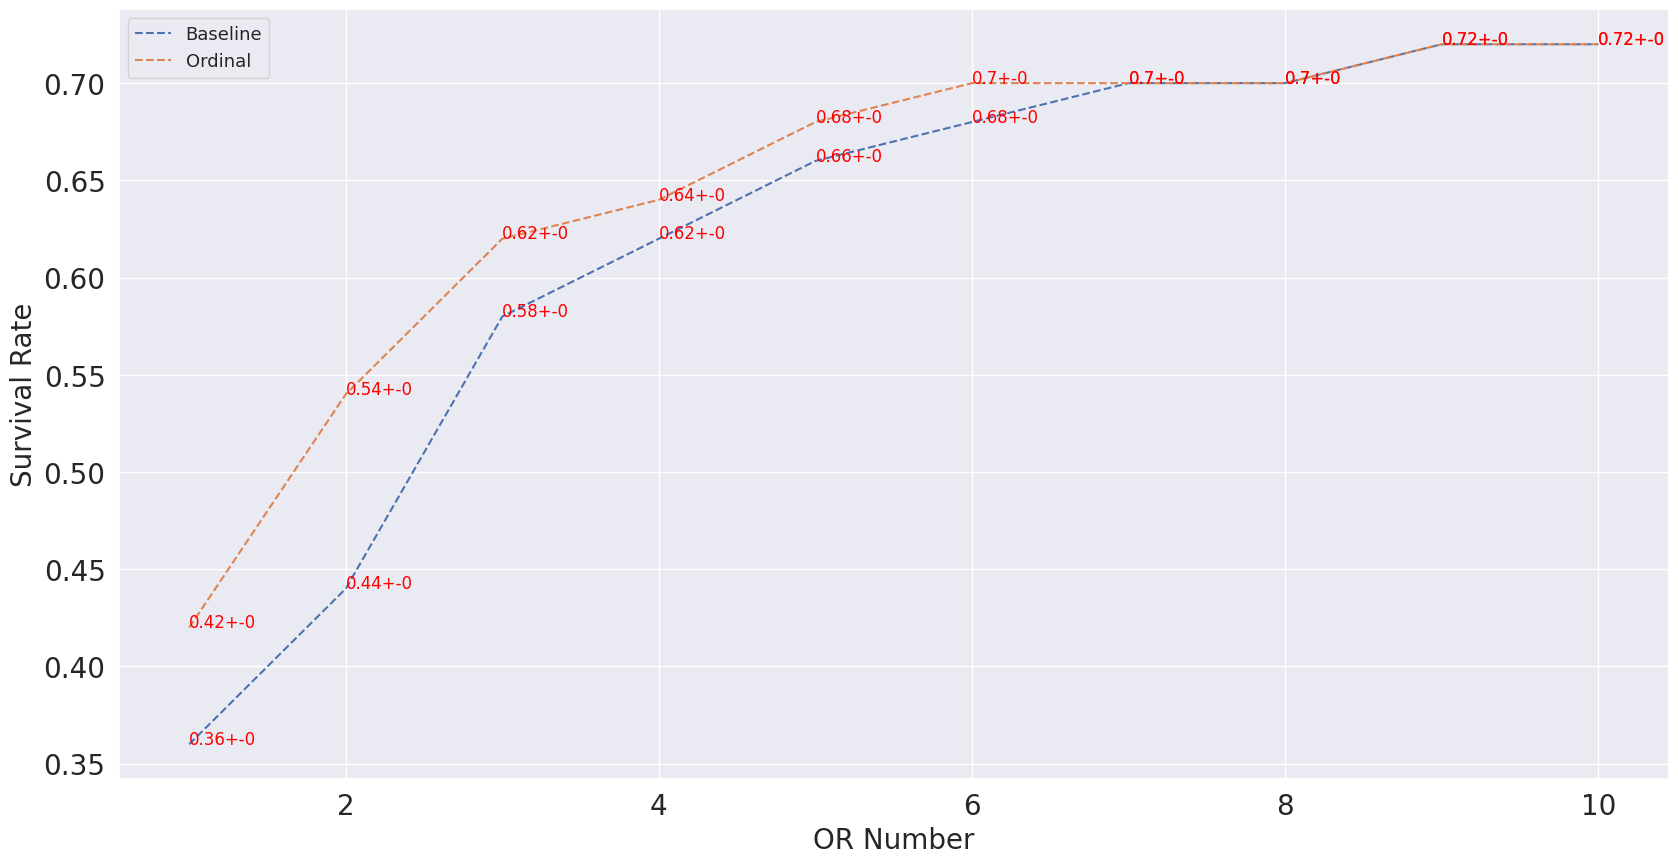

dictionary saved successfully to file


In [ ]:
experiment_capacity_of_OR()

In [ ]:
@plotAverage
def experiment_capacity_of_CT():
    params = get_default_params()
    paperParameter = createParameter(**params)
    paperParameter['env']['orRoomNumber'] = 3
    x=np.arange(1, 11)
    agents = {'Baseline': BaselineAgent,
              'Ordinal': OrdinalTriageAgent
            }
    y = []
    for name, agent in agents.items():
        print('Policy name:', name)
        survivalRates = []
        survivalRatesHW = []
        benifitSurvivalRates = []
        benifitSurvivalRatesHW = []
        for ctRoomNumber in range(1, 11):
            parameter = copy.copy(paperParameter)
            paperParameter['env']['ctRoomNumber'] = ctRoomNumber
            parameter['output'] = os.path.join(parameter['output'], name)
            if name == 'Ordinal':
                parameter['agent']['threshold'] = 103
            res = simulation(MultiClassMCIEnv, agent, parameter)
            #1. survival rate
            survivalRates.append(res['survivalRateStat'].mean()[-1])
            survivalRatesHW.append(res['survivalRateStat'].half_window(0.95)[-1])
            #2. benifit survival rate
            benifitSurvivalRates.append(res['benefitSurvivalRateStat'].mean()[-1])
            benifitSurvivalRatesHW.append(res['benefitSurvivalRateStat'].half_window(0.95)[-1])
        y.append({'label':name, 'average_data': survivalRates, 'half_window': survivalRatesHW})
        #y.append({'label':name+' (PWB)', 'average_data': benifitSurvivalRates, 'half_window': benifitSurvivalRatesHW})
    res = {'x':{'label': 'CT Number', 'data': x}, 'y': y}
    pprint(res)
    return res


In [ ]:
experiment_capacity_of_CT()

In [ ]:
@plotAverage
def experiment_survivalTime():
    params = get_default_params()
    classProbs, subclassProbs, impatientAverages = np.array(params['classProbs']), np.array(params['subclassProbs']), np.array(params['impatientAverages'])
    expectImpatient = np.sum(np.sum(subclassProbs*impatientAverages, axis=1)*classProbs)
    x = [i*100 for i in range(1, 9)]
    agents = {'Baseline': BaselineAgent,
              'Ordinal': OrdinalTriageAgent
            }
    y = []
    for name, agent in agents.items():
        print('Policy name:', name)
        survivalRates = []
        survivalRatesHW = []
        benifitSurvivalRates = []
        benifitSurvivalRatesHW = []
        for i in range(1, 9):
            ratio = (i*100)/expectImpatient
            params = get_default_params()
            params['impatientAverages'] = (ratio*impatientAverages).tolist()
            parameter = createParameter(**params)
            parameter['output'] = os.path.join(parameter['output'], name)
            if name == 'Ordinal':
                parameter['agent']['threshold'] = 103
            res = simulation(MultiClassMCIEnv, agent, parameter)
            #1. survival rate
            survivalRates.append(res['survivalRateStat'].mean()[-1])
            survivalRatesHW.append(res['survivalRateStat'].half_window(0.95)[-1])
            #2. benefit survival rate
            benifitSurvivalRates.append(res['benefitSurvivalRateStat'].mean()[-1])
            benifitSurvivalRatesHW.append(res['benefitSurvivalRateStat'].half_window(0.95)[-1])
        y.append({'label':name, 'average_data': survivalRates, 'half_window': survivalRatesHW})
        #y.append({'label':name+' (PWB)', 'average_data': benifitSurvivalRates, 'half_window': benifitSurvivalRatesHW})
    res = {'x':{'label': 'Total Average Survival Time', 'data': x}, 'y': y}
    pprint(res)
    return res

In [ ]:
experiment_survivalTime()

In [ ]:
@plotAverage
def experiment_proportion_of_benefit():
    x = [i*0.1 for i in range(11)]
    agents = {'Baseline': BaselineAgent,
              'Ordinal': OrdinalTriageAgent
            }
    y = []
    for name, agent in agents.items():
        print('Policy name:', name)
        survivalRates = []
        survivalRatesHW = []
        benifitSurvivalRates = []
        benifitSurvivalRatesHW = []
        for i in range(11):
            notBenefitProb = i*0.1
            params = get_default_params()
            params['notBenefitProb'] = notBenefitProb
            parameter = createParameter(**params)
            parameter['output'] = os.path.join(parameter['output'], name)
            if name == 'Ordinal':
                parameter['agent']['threshold'] = 103
            res = simulation(MultiClassMCIEnv, agent, parameter)
            #1. survival rate
            survivalRates.append(res['survivalRateStat'].mean()[-1])
            survivalRatesHW.append(res['survivalRateStat'].half_window(0.95)[-1])
            #2. benefit survival rate
            benifitSurvivalRates.append(res['benefitSurvivalRateStat'].mean()[-1])
            benifitSurvivalRatesHW.append(res['benefitSurvivalRateStat'].half_window(0.95)[-1])
        y.append({'label':name, 'average_data': survivalRates, 'half_window': survivalRatesHW})
        #y.append({'label':name+' (PWB)', 'average_data': benifitSurvivalRates, 'half_window': benifitSurvivalRatesHW})
    res = {'x':{'label': 'Ratio of Patients who do not Benefit from Surgery', 'data': x}, 'y': y}
    pprint(res)
    return res

In [ ]:
experiment_proportion_of_benefit()

In [ ]:
@plotAverage
def experiment_init_number_of_patients():
    x = [i*10 for i in range(1, 11)]
    agents = {'Baseline': BaselineAgent,
              'Ordinal': OrdinalTriageAgent
            }
    y = []
    for name, agent in agents.items():
        print('Policy name:', name)
        survivalRates = []
        survivalRatesHW = []
        benifitSurvivalRates = []
        benifitSurvivalRatesHW = []
        for i in range(1, 11):
            params = get_default_params()
            params['patientNumber'] = i*10
            parameter = createParameter(**params)
            parameter['output'] = os.path.join(parameter['output'], name)
            if name == 'Ordinal':
                parameter['agent']['threshold'] = 103
            res = simulation(MultiClassMCIEnv, agent, parameter)
            #1. survival rate
            survivalRates.append(res['survivalRateStat'].mean()[-1])
            survivalRatesHW.append(res['survivalRateStat'].half_window(0.95)[-1])
            #2. benefit survival rate
            benifitSurvivalRates.append(res['benefitSurvivalRateStat'].mean()[-1])
            benifitSurvivalRatesHW.append(res['benefitSurvivalRateStat'].half_window(0.95)[-1])
        y.append({'label':name, 'average_data': survivalRates, 'half_window': survivalRatesHW})
        #y.append({'label':name+' (PWB)', 'average_data': benifitSurvivalRates, 'half_window': benifitSurvivalRatesHW})
    res = {'x':{'label': 'Total Number of Patients', 'data': x}, 'y': y}
    pprint(res)
    return res

In [ ]:
experiment_init_number_of_patients()

In [ ]:
@plotHeatMap
def experiment_survivalTime_ORNumber():

    params = get_default_params()
    classProbs, subclassProbs, impatientAverages = np.array(params['classProbs']), np.array(params['subclassProbs']), np.array(params['impatientAverages'])
    expectImpatient = np.sum(np.sum(subclassProbs*impatientAverages, axis=1)*classProbs)
    x = [i for i in range(1, 11)]
    y = [j*100 for j in range(1, 11)]
    agents = {
              'Ordinal': OrdinalTriageAgent
            }
    means = []
    half_windows = []
    for survivalTime in y:
        survivalRates = []
        survivalRatesHW = []
        for orNumber in x:
            ratio = survivalTime/expectImpatient
            params = get_default_params()
            params['orRoomNumber'] = orNumber
            params['impatientAverages'] = (ratio*impatientAverages).tolist()
            parameter = createParameter(**params)
            parameter['output'] = os.path.join(parameter['output'], 'Ordinal')
            parameter['agent']['threshold'] = 103
            res = simulation(MultiClassMCIEnv, OrdinalTriageAgent, parameter)
            #1. survival rate
            survivalRates.append(res['survivalRateStat'].mean()[-1])
            survivalRatesHW.append(res['survivalRateStat'].half_window(0.95)[-1])
        means.append(survivalRates)
        half_windows.append(survivalRatesHW)
    res = {'x': {'label':'OR number', 'values': x} ,
           'y': {'label':'survival time', 'values': y},
           'data': {'mean': means, 'half_window': half_windows}}
    pprint(res)
    return res
experiment_survivalTime_ORNumber()


{'x': {'label': 'time', 'data': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.998e+03, 1.999e+03,
       2.000e+03])}, 'y': [{'label': 'Baseline', 'average_data': array([1.     , 0.99956, 0.99892, ..., 0.45736, 0.45736, 0.45736]), 'half_window': array([0.        , 0.00025803, 0.00039758, ..., 0.00490858, 0.00490858,
       0.00490858])}, {'label': 'Ordinal', 'average_data': array([1.     , 0.99956, 0.99892, ..., 0.50684, 0.50684, 0.50684]), 'half_window': array([0.        , 0.00025803, 0.00039758, ..., 0.00538431, 0.00538431,
       0.00538431])}]}


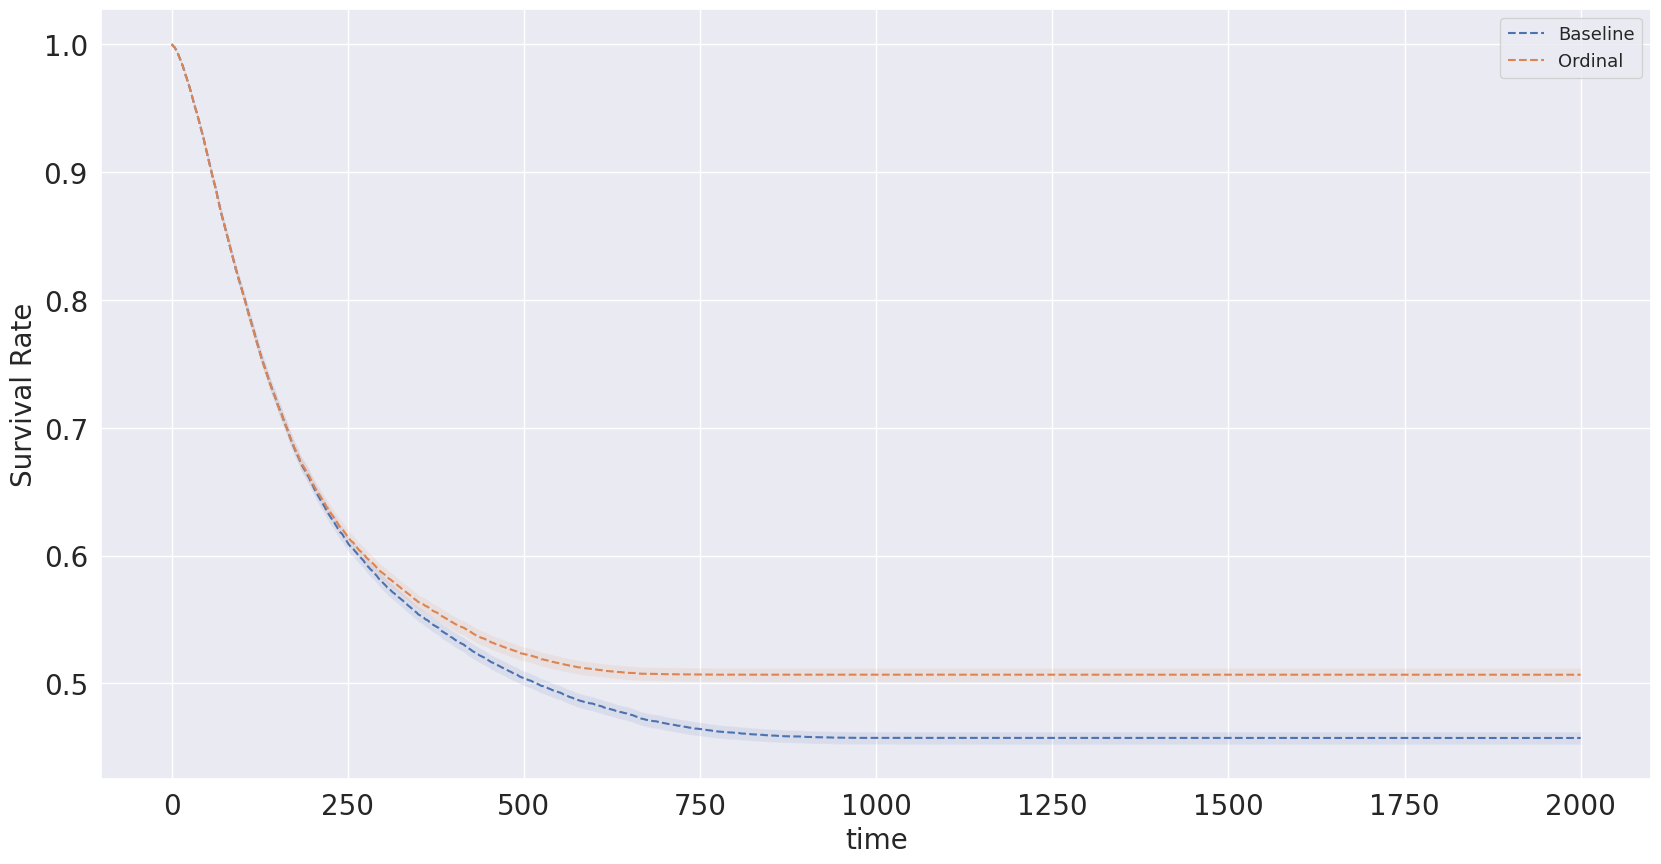

{'x': {'label': 'CT Number', 'data': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}, 'y': [{'label': 'Baseline', 'average_data': array([0.45736, 0.45736, 0.45736, 0.45736, 0.45736, 0.45736, 0.45736,
       0.45736, 0.45736, 0.45736]), 'half_window': array([0.00490858, 0.00490858, 0.00490858, 0.00490858, 0.00490858,
       0.00490858, 0.00490858, 0.00490858, 0.00490858, 0.00490858])}, {'label': 'Ordinal', 'average_data': array([0.4964 , 0.50684, 0.51136, 0.51284, 0.51312, 0.51316, 0.51304,
       0.51288, 0.513  , 0.51288]), 'half_window': array([0.00547056, 0.00538431, 0.00563379, 0.00552186, 0.00556868,
       0.00555515, 0.00554787, 0.00555745, 0.00555027, 0.00554741])}]}


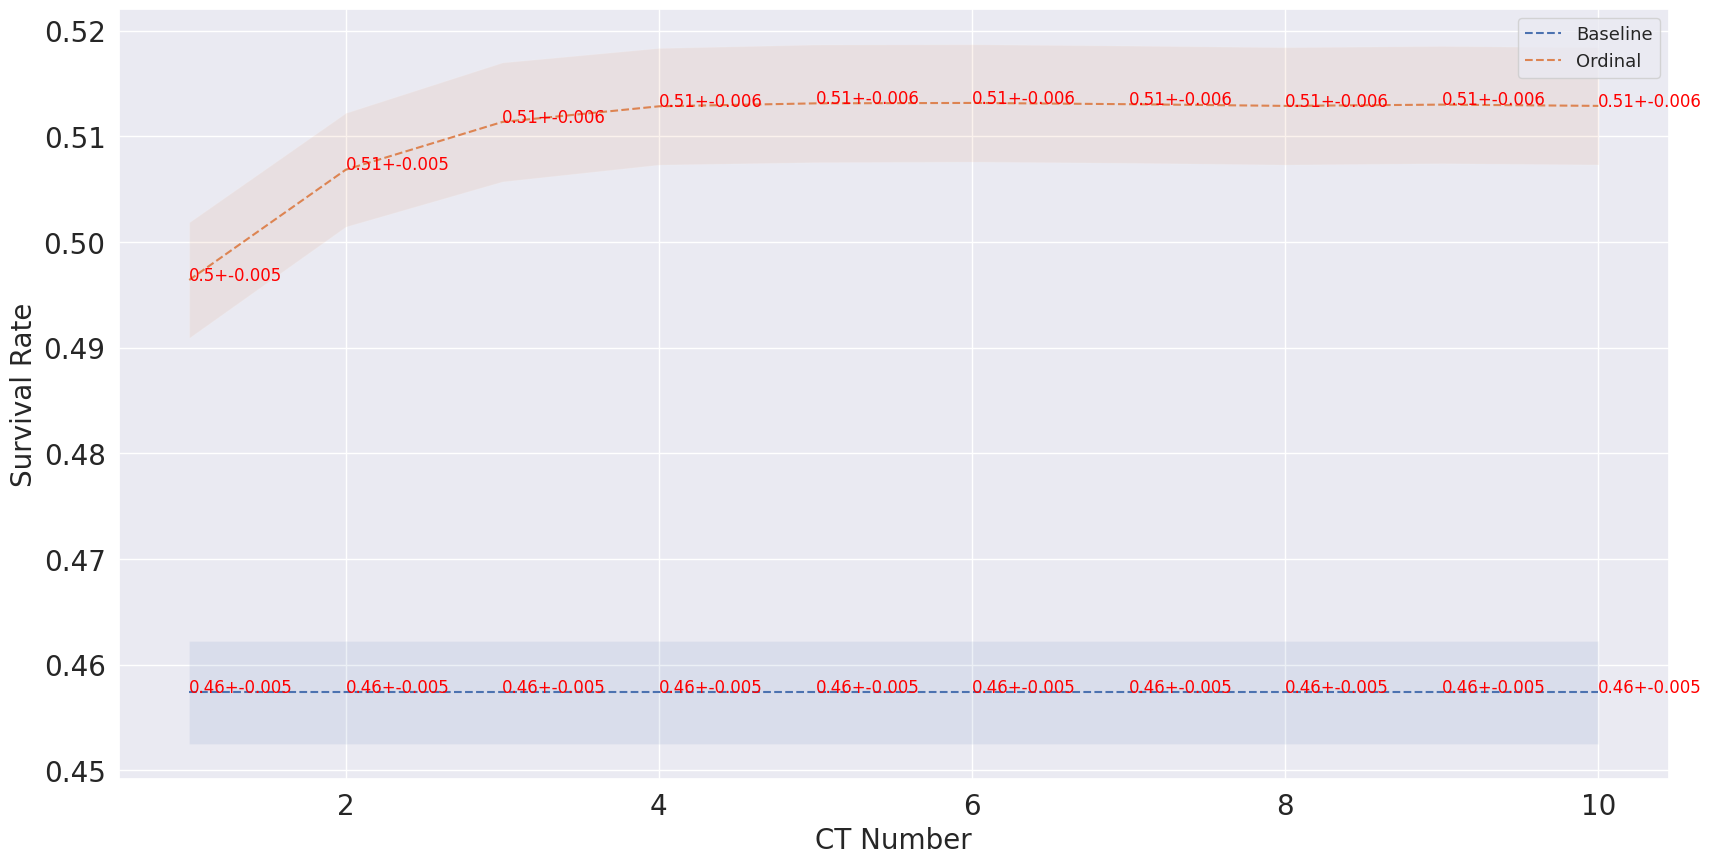

{'x': {'data': [100, 200, 300, 400, 500, 600, 700, 800], 'label': 'Total Average Survival Time'}, 'y': [{'average_data': [0.2697600000000003, 0.35488000000000003, 0.42223999999999956, 0.47787999999999986, 0.5209199999999996, 0.5557200000000001, 0.5841200000000003, 0.6102800000000006], 'half_window': [0.004995830521222919, 0.0048233305643567885, 0.004936513391928505, 0.0049475669419513915, 0.00494541502180966, 0.004765807866906421, 0.004902582209597372, 0.005006950882187577], 'label': 'Baseline'}, {'average_data': [0.3037599999999997, 0.39740000000000036, 0.47352000000000044, 0.5267200000000001, 0.5700399999999998, 0.6104799999999995, 0.6440399999999991, 0.672599999999999], 'half_window': [0.005503563706753639, 0.005472113279774346, 0.0055031049006432405, 0.005621067681710152, 0.005531978999440089, 0.0054767267041615835, 0.0055048398412270135, 0.005392366339074275], 'label': 'Ordinal'}]}


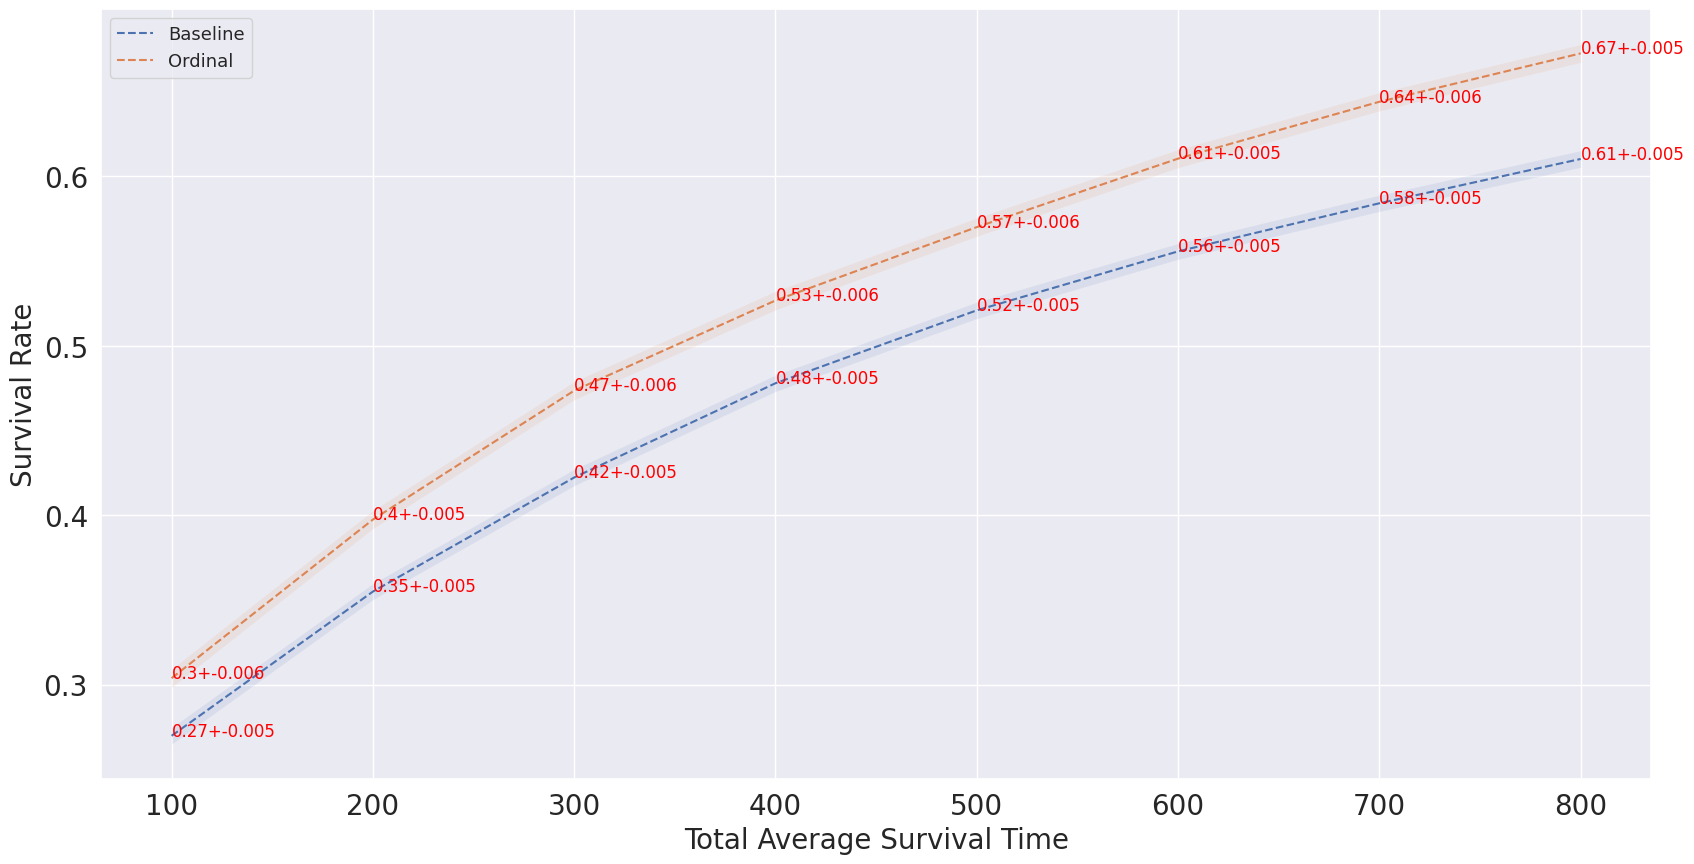

{'x': {'label': 'Ratio of Patients who do not Benefit from Surgery', 'data': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]}, 'y': [{'label': 'Baseline', 'average_data': array([0.33508, 0.38452, 0.44124, 0.4988 , 0.559  , 0.62332, 0.68944,
       0.76212, 0.8398 , 0.91704, 1.     ]), 'half_window': array([0.00427185, 0.00450641, 0.0048895 , 0.00507892, 0.00521097,
       0.00514973, 0.00519006, 0.00500972, 0.00454708, 0.00340101,
       0.        ])}, {'label': 'Ordinal', 'average_data': array([0.33768, 0.41104, 0.48524, 0.55744, 0.62356, 0.69028, 0.75564,
       0.822  , 0.88344, 0.9418 , 1.     ]), 'half_window': array([0.00417257, 0.00483897, 0.00544043, 0.00549427, 0.00553095,
       0.00531046, 0.0051365 , 0.00473905, 0.00407497, 0.00284616,
       0.        ])}]}


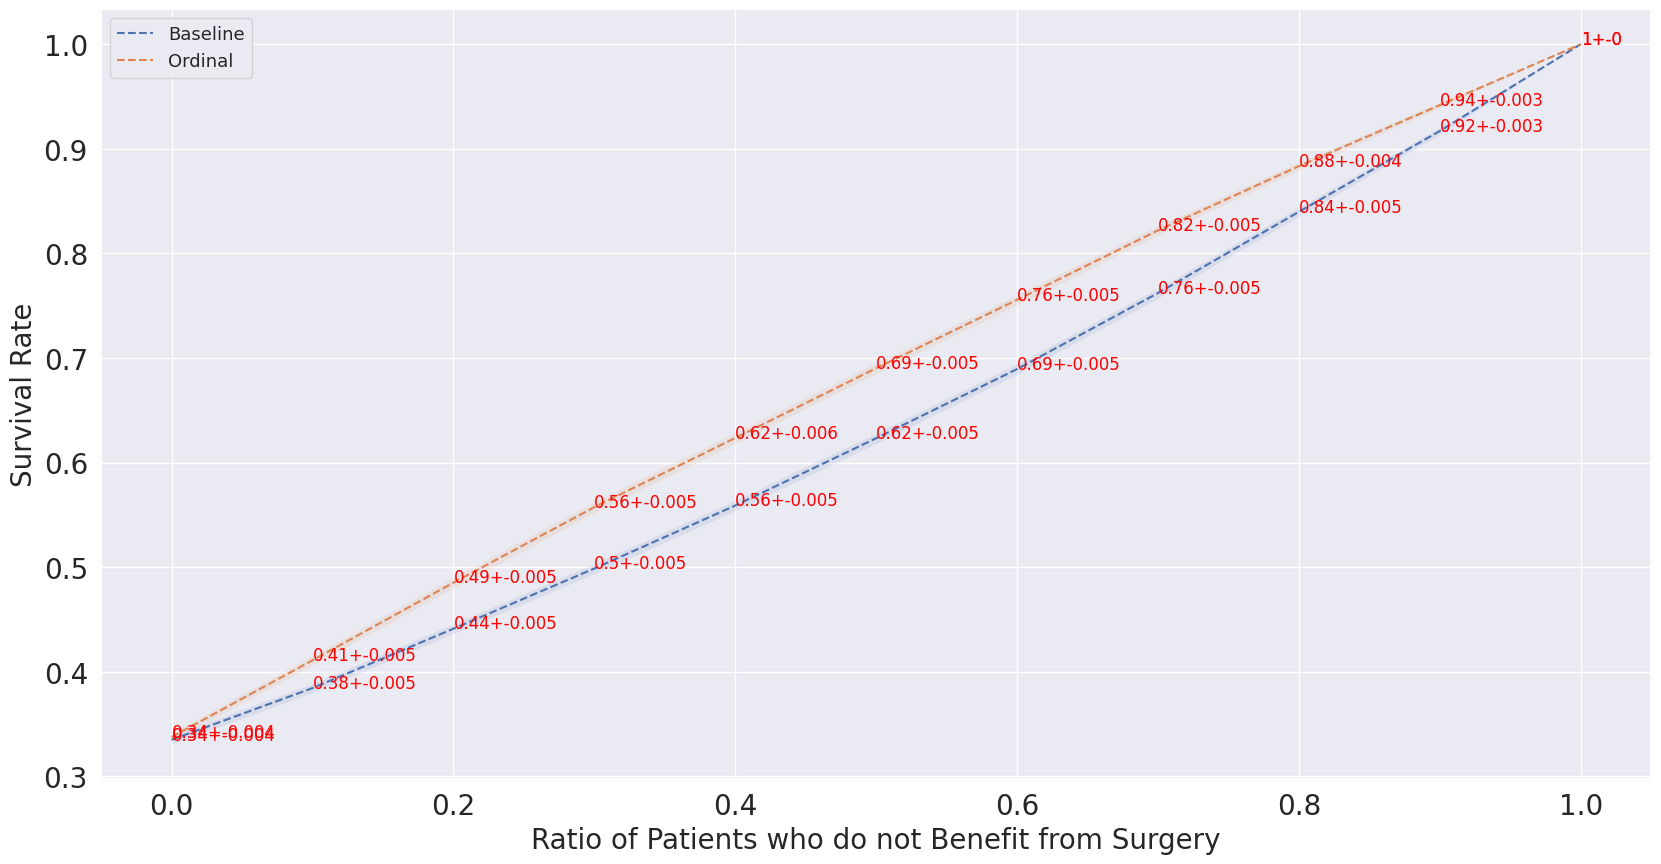

{'x': {'label': 'Total Number of Patients', 'data': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}, 'y': [{'label': 'Baseline', 'average_data': array([0.696     , 0.603     , 0.5396    , 0.49335   , 0.45736   ,
       0.42863333, 0.40642857, 0.38685   , 0.37077778, 0.35844   ]), 'half_window': array([0.01113366, 0.00806154, 0.00635639, 0.00556581, 0.00490858,
       0.00449875, 0.00409687, 0.00365782, 0.00351557, 0.00327485])}, {'label': 'Ordinal', 'average_data': array([0.6978    , 0.628     , 0.57453333, 0.53645   , 0.50684   ,
       0.48293333, 0.46197143, 0.447525  , 0.43133333, 0.41666   ]), 'half_window': array([0.01126873, 0.00838376, 0.00651904, 0.00616781, 0.00538431,
       0.00500112, 0.00478646, 0.0042425 , 0.00411885, 0.00393521])}]}


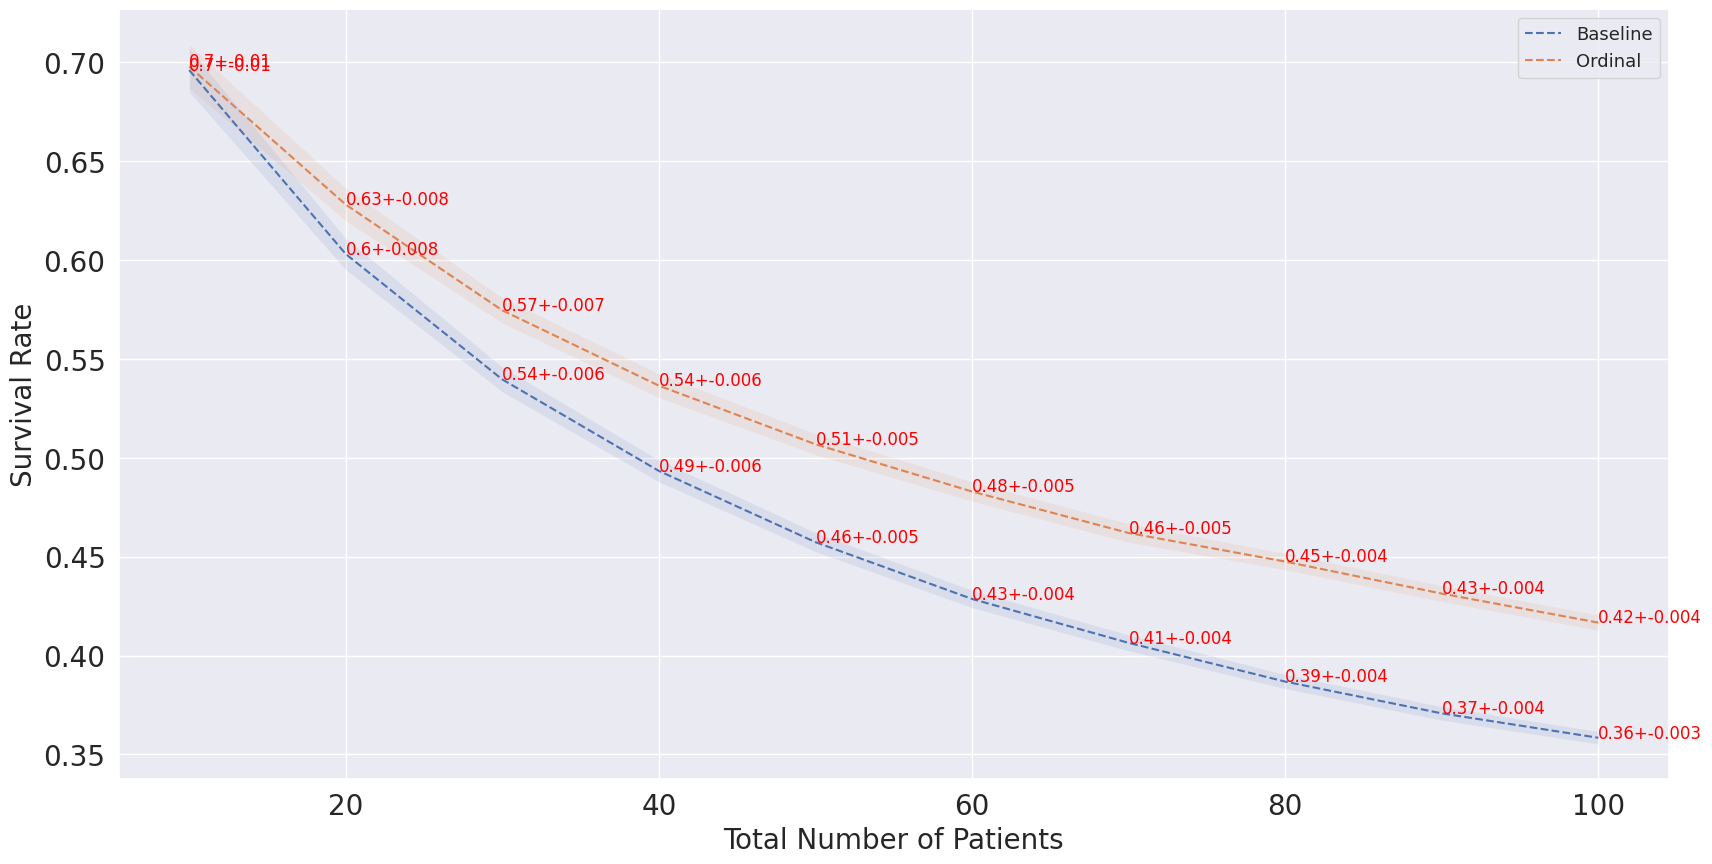

In [ ]:
plotSavedExperiment('experiment_time', False)
#plotSavedExperiment('experiment_capacity_of_OR')
plotSavedExperiment('experiment_capacity_of_CT')
plotSavedExperiment('experiment_survivalTime')
plotSavedExperiment('experiment_proportion_of_benefit')
plotSavedExperiment('experiment_init_number_of_patients')

{'x': {'label': 'OR number', 'values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, 'y': {'label': 'survival time', 'values': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}, 'data': {'mean': [[0.28, 0.34, 0.34, 0.36, 0.42, 0.42, 0.44, 0.5, 0.48, 0.52], [0.34, 0.4, 0.46, 0.52, 0.54, 0.56, 0.58, 0.6, 0.6, 0.62], [0.4, 0.52, 0.54, 0.62, 0.66, 0.66, 0.66, 0.68, 0.72, 0.72], [0.42, 0.56, 0.64, 0.68, 0.7, 0.72, 0.72, 0.72, 0.78, 0.78], [0.48, 0.64, 0.66, 0.7, 0.76, 0.78, 0.76, 0.76, 0.82, 0.82], [0.54, 0.66, 0.72, 0.78, 0.78, 0.78, 0.84, 0.84, 0.84, 0.84], [0.56, 0.68, 0.74, 0.78, 0.82, 0.84, 0.84, 0.86, 0.84, 0.86], [0.58, 0.7, 0.74, 0.78, 0.82, 0.86, 0.86, 0.86, 0.86, 0.86], [0.6, 0.7, 0.74, 0.84, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86], [0.66, 0.72, 0.78, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86]], 'half_window': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

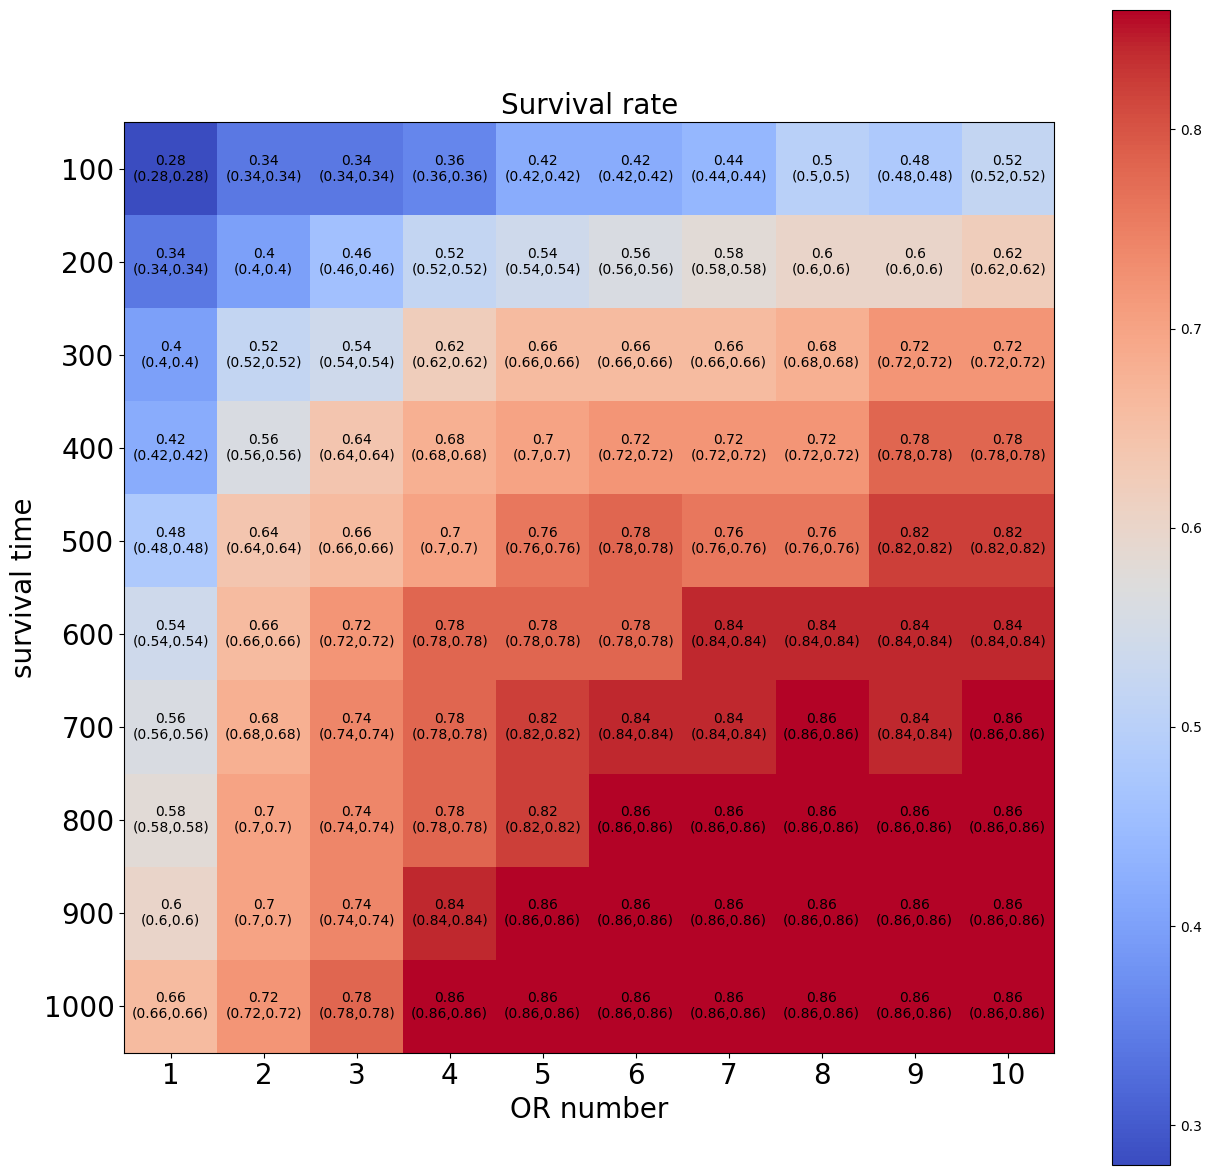

In [ ]:
directoryPath = "/content/drive/MyDrive/MCIScheduling"
with open(os.path.join(directoryPath, 'experiment_survivalTime_ORNumber'+'.pkl'), 'rb') as fp:
    data = pickle.load(fp)
    print(data)
    heatMap(data)

In [ ]:
def getTestPatients(number):
    classProbs = [0.27, 0.73]
    subclassProbs = [[0.8, 0.2], [0.4, 0.6]]
    notBenefitProb = 0.23
    impatientAverages = [[200, 450], [100, 600]]
    imagingAverages = [12, 12]
    imagingStds = [3, 3]
    surgeryAverages = [103, 103]
    surgeryStds = [30, 30]
    patientGenerator = PatientGenerator(classProbs, subclassProbs, notBenefitProb, impatientAverages, imagingAverages, imagingStds, surgeryAverages, surgeryStds, 42)
    return patientGenerator.rvs(number)
import time
patients = getTestPatients(50)
impatientAverages = [[200, 450], [100, 600], [300, 500]]
subclassProbs = [[0.8, 0.2], [0.4, 0.6], [0.5, 0.5]]
mciModel = FastMultiClassMCIEnv(patients, impatientAverages, subclassProbs, 2, 3)
agent = BaselineAgent(mciModel)
s = time.time()
for _ in range(100):
    state = mciModel.reset()
    done = False
    info = {'where': {'CT','OR'}}
    while not done:
        action = agent.chooseAction(state, info)
        state, reward, done, info = mciModel.step(action)
print(time.time()-s)
mciModel.patients[['abandonTime','isAbandon','leaveTime']]